In [1]:
import numpy as np
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization


from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [2]:
train_path = 'XRays/train'
valid_path = 'XRays/valid'
test_path = 'XRays/test'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog','cat','monkey','cow'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog','cat','monkey','cow'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog','cat','monkey','cow'], batch_size=4)

Found 19 images belonging to 4 classes.
Found 2 images belonging to 4 classes.
Found 21 images belonging to 4 classes.


In [4]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs, labels = next(train_batches)

c:\python39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


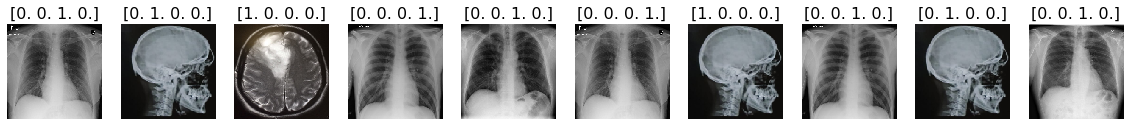

In [6]:
plots(imgs, titles=labels)

In [7]:
train_batches.class_indices

{'dog': 0, 'cat': 1, 'monkey': 2, 'cow': 3}

In [8]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
vgg16_model = keras.applications.vgg16.VGG16()

In [10]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
type(vgg16_model)

keras.engine.functional.Functional

In [12]:
model = Sequential()
for i in vgg16_model.layers:
    model.add(i)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
model.layers.pop()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [15]:
for layer in model.layers:
    layer.trainable = False

In [16]:
model.add(Dense(4, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [18]:
model.compile(Adam(lr=0.07), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\kucaa\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
history=model.fit_generator(train_batches, steps_per_epoch=1, 
                    validation_data=valid_batches, validation_steps=1, epochs=30, verbose=2)

Epoch 1/30


C:\Users\kucaa\AppData\Local\Temp/ipykernel_20292/714571501.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_batches, steps_per_epoch=1,


1/1 - 2s - loss: 1.3827 - accuracy: 0.2222 - val_loss: 1.3228 - val_accuracy: 0.5000 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 1s - loss: 1.3242 - accuracy: 0.6667 - val_loss: 1.3032 - val_accuracy: 0.5000 - 1s/epoch - 1s/step
Epoch 3/30
1/1 - 1s - loss: 1.2630 - accuracy: 0.6667 - val_loss: 1.2676 - val_accuracy: 0.5000 - 1s/epoch - 1s/step
Epoch 4/30
1/1 - 2s - loss: 1.2174 - accuracy: 0.6000 - val_loss: 1.2349 - val_accuracy: 0.5000 - 2s/epoch - 2s/step
Epoch 5/30
1/1 - 1s - loss: 1.1801 - accuracy: 0.5556 - val_loss: 1.2151 - val_accuracy: 0.5000 - 1s/epoch - 1s/step
Epoch 6/30
1/1 - 1s - loss: 1.0774 - accuracy: 0.6667 - val_loss: 1.2063 - val_accuracy: 0.5000 - 1s/epoch - 1s/step
Epoch 7/30
1/1 - 2s - loss: 1.1473 - accuracy: 0.6000 - val_loss: 1.1909 - val_accuracy: 0.5000 - 2s/epoch - 2s/step
Epoch 8/30
1/1 - 2s - loss: 0.8947 - accuracy: 0.8889 - val_loss: 1.1809 - val_accuracy: 0.5000 - 2s/epoch - 2s/step
Epoch 9/30
1/1 - 2s - loss: 0.8486 - accuracy: 0.8889 - val_loss: 1.1784 - 

In [20]:
model.save_weights('model_weights.h5')

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
[[0.577831   0.3278143  0.05349264 0.04086212]
 [0.3987514  0.5163034  0.05359421 0.0313509 ]
 [0.03691979 0.04619711 0.8224348  0.09444824]
 [0.3987514  0.5163034  0.05359421 0.0313509 ]]


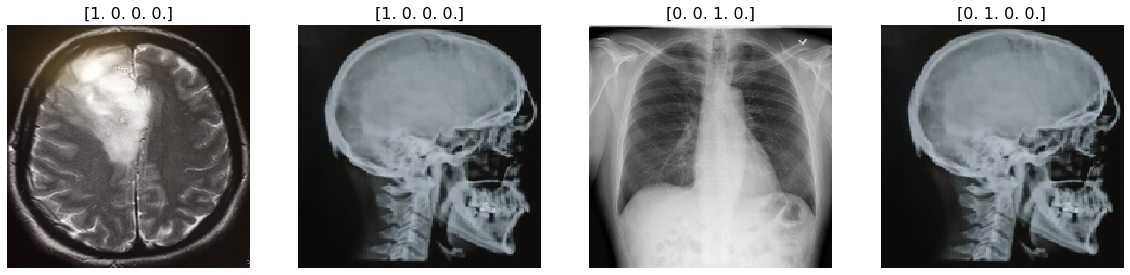

In [21]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)
print(test_labels)
predictions = model.predict_on_batch(np.array(test_imgs))
print(predictions)
test_labels = np.array(test_labels.argmax(axis=1))
predictions = np.array(predictions.argmax(axis=1))

In [22]:
print(test_labels)
print(predictions)

[0 0 2 1]
[0 1 2 1]


In [23]:
cm = confusion_matrix(test_labels, predictions)

In [24]:
cm_plot_labels = ['No Disease in Chest','Possible Disease in Chest','No Disease in Brain','Possible Disease in Brain']
if 0 not in test_labels and 0 not in predictions:
    cm_plot_labels.remove('No Disease in Chest')
if 1 not in test_labels and 1 not in predictions:
    cm_plot_labels.remove('Possible Disease in Chest')
if 2 not in test_labels and 2 not in predictions:
    cm_plot_labels.remove('No Disease in Brain')
if 3 not in test_labels and 3 not in predictions:
    cm_plot_labels.remove('Possible Disease in Brain')

Confusion matrix, without normalization
[[1 1 0]
 [0 1 0]
 [0 0 1]]


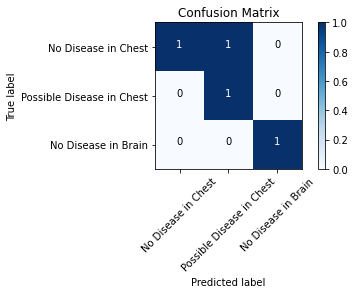

In [25]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

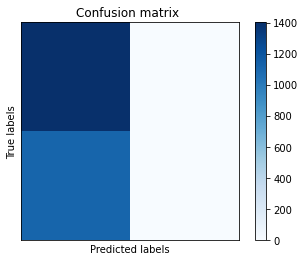

In [26]:
cm = np.array([[1401,    0],[1112, 0]])

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

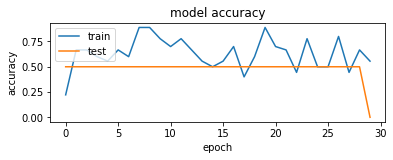

In [32]:
 plt.subplot(211)  
 plt.plot(history.history['accuracy'])  
 plt.plot(history.history['val_accuracy'])  
 plt.title('model accuracy')  
 plt.ylabel('accuracy')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  

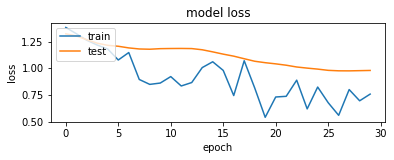

In [28]:
 plt.subplot(212)  
 plt.plot(history.history['loss'])  
 plt.plot(history.history['val_loss'])  
 plt.title('model loss')  
 plt.ylabel('loss')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  
 plt.show() 

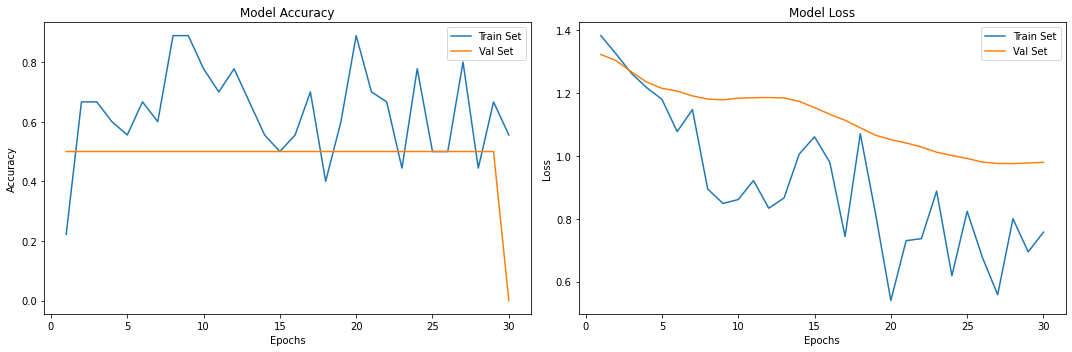

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()